### Aim

The aim of this lab is to review tools for visualizing functions of two variables and to introduce optimization methods.

### Objectives

At the end of this lab, students should be able to:
1. Plots level curves and the graphs of functions of two variables
2. Implement gradient descent to find the minimum of a function of several variables
3. Implement particle swarm optimization to find the minimum of a function of several variables

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from matplotlib.animation import FuncAnimation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Background Knowledge

## Vizualising functions of two variables

One can visualize functions of two variables in Python by plotting level curves and surfaces. The libraries that we need for plotting functions are `matplotlib` (level curves) and `mpl_toolkits.mplot3d` (surfaces).

For example, consider the function $f(x,y)=x^3-xy^2$.

### Data preparation

Before visualizing a function of two variables, we need to prepare the data by computing the set of $x$-, $y$- and $z$- values needed for the plot. For instance, below we prepare data for a hypothetical plot of the function $f(x,y)$ for $x=1,2,3,4$ and $y=0, 1, 2, 3, 4, 5$. Note the command `meshgrid` from the package *numpy*:

In [2]:
X, Y = np.meshgrid(np.arange(1, 5),
                   np.arange(0, 6))
Z = X ** 3 - X * Y ** 2

In [3]:
print("X = ", X)

X =  [[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]


In [4]:
print("Y = ", Y)

Y =  [[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]
 [5 5 5 5]]


In [5]:
print("Z = ", Z)

Z =  [[  1   8  27  64]
 [  0   6  24  60]
 [ -3   0  15  48]
 [ -8 -10   0  28]
 [-15 -24 -21   0]
 [-24 -42 -48 -36]]


### Level curves

A *contour plot* shows level curves of a function $f(x,y)$. It is the easiest one to produce in Python - a 3D plotting functionality is not required for it.

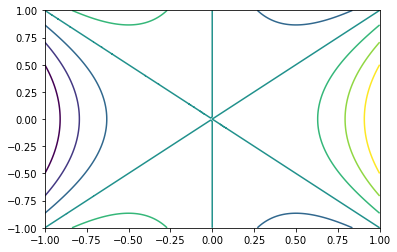

In [6]:
X, Y = np.meshgrid(np.linspace(-1, 1, 201),
                   np.linspace(-1, 1, 201))
Z = X ** 3 - X * Y ** 2

plt.contour(X, Y, Z)
plt.show()

Below is a plot with labels and a title. For more information, you are encouraged to read the manual on the function `contour`. It may help you with Calculus III.

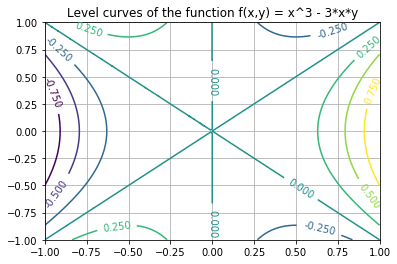

In [7]:
plt.figure()
my_plot = plt.contour(X, Y, Z)
plt.clabel(my_plot, inline=1, fontsize=10)
plt.title('Level curves of the function f(x,y) = x^3 - 3*x*y')
plt.grid(True)
plt.show()

### Wireframe plot

For 3D plotting, we need the library `mpl_toolkits.mplot3d`. Below is the most basic surface plot.

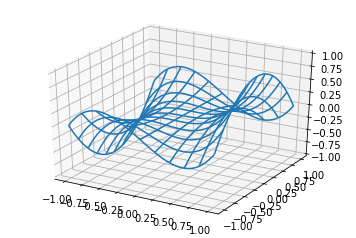

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=20, cstride=20)

plt.show()

We can change the viewing angle as follows:

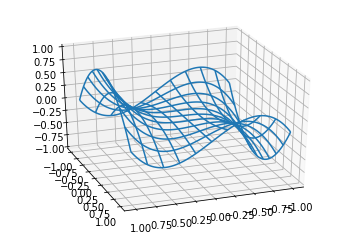

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z, rstride=20, cstride=20)
ax.view_init(30, 70)

plt.show()

Or we can even make a spinning figure

In [10]:
def plot_func(angle):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=20, cstride=20)
    ax.view_init(30, angle)
    plt.draw()

In [11]:
interact(plot_func, angle = widgets.Play(value = 0,
                                         min = 0,
                                         max = 360,
                                         step = 1,
                                         description = "Angle",
                                         disabled = False
))

interactive(children=(Play(value=0, description='Angle', max=360), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_func(angle)>

### Surface plot

Note that the parameter `cmap` means *color map*. You can see the list of available color maps [here](http://mpastell.com/2013/05/02/matplotlib_colormaps/).


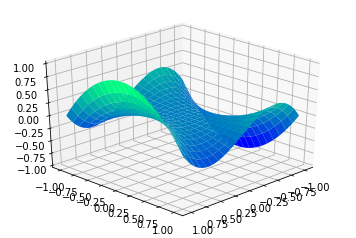

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, rstride=10, cstride=10,
                    cmap = plt.cm.winter)
ax.view_init(30, 45)

plt.show()

# Gradient descent


## Motivation

Suppose we have a set of observations of two random variables, $X$ and $Y$ and we believe that there is a relationship $Y=f(X)+\varepsilon$, where $\varepsilon$ is random noise. We want to figure out the most likely form of $f(X)$.

### Example: linear regression

Below we generate and plot some random data.

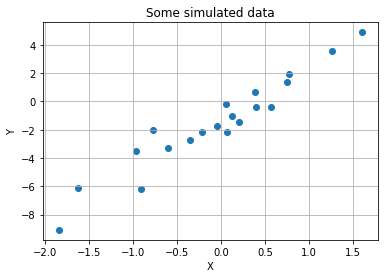

In [13]:
X = np.random.randn(20)
Y = -1.5 + 3.5 * X - np.random.randn(20)
plt.scatter(X, Y)
plt.grid(True)
plt.title('Some simulated data')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Assuming a true linear relationship $Y=a+bX$, we want to guess the most likely values of $a$ and $b$ from the data. Depending on the values of $a$ and $b$, the model $Y=a+bX$, may be a better or a worse fit to the data. Below are two examples.

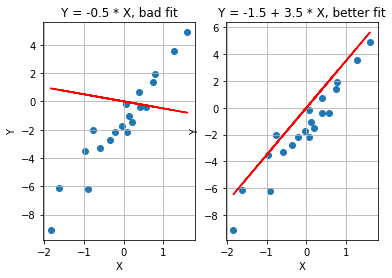

In [14]:
plt.subplot(1, 2, 1)

plt.scatter(X, Y)
plt.plot(X, -0.5 * X, 'red')
plt.grid(True)
plt.title('Y = -0.5 * X, bad fit')
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1, 2, 2)
plt.scatter(X, Y)
plt.plot(X, 3.5 * X, 'red')
plt.grid(True)
plt.title('Y = -1.5 + 3.5 * X, better fit')
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

To define how good / bad a fit is, the *cost function* or the *error function* is introduced. Probably, the most common cost function in statistics is the *ordinary least squares* or the *mean squared error* defined as
$$
E(a,b) = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i-y_i)^2 = \frac{1}{m}\sum_{i=1}^{m}(a+bx_i-y_i)^2,
$$
where $\hat{y}_i=a+bx_i$ is the value of $y_i$ predicted by the model. Here, $(x_1,y_1),\cdots,(x_m,y_m)$ are individual observations.

The values of $a$ and $b$ that are best fit to the observed data are those minimizing the cost function, i.e.,
$$
(a,b)=\arg\min E(a,b).
$$

For a linear regression, it is not hard to find the values of $a$ and $b$ directly. Indeed, first note that the cost function is convex (Hessian is positive definite) and therefore if a critical point exists, it is unique and it has to be a point of global minimum. Second, the critical point can be found by solving the system
\begin{align*}
\frac{\partial E}{\partial a} & = \frac{2}{m}\sum_{i=1}^{m}(a+bx_i-y_i)=2a+b\cdot \frac{2\sum_{i=1}^{m}x_i}{m}-
\frac{2}{m}\sum_{i=1}^{m}y_i=0,\\
\frac{\partial E}{\partial b} & = \frac{2}{m}\sum_{i=1}^{m}(a+bx_i-y_i)\cdot x_i=
2a+ b\cdot\frac{2\sum_{i=1}^{m}x_i^2}{m}-
\frac{2}{m}\sum_{i=1}^{m}x_iy_i=0.
\end{align*}
Note that this is a linear system in $a$ and $b$ and it can be easily solved explicitly.

### Example: logistic regression

In *classification* problems, the dependent variable $Y$ takes two values, $0$ and $1$. Let's generate some data

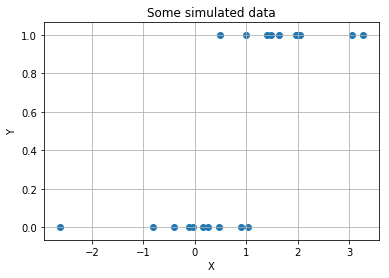

In [15]:
X = np.concatenate((np.random.randn(10), 2 + np.random.randn(10)))
Y = np.concatenate((np.zeros(10), np.ones(10)))
plt.scatter(X, Y)
plt.grid(True)
plt.title('Some simulated data')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Now, if $Y\in\{0,1\}$, it does not make sense to fit a linear model $Y=a+bX+\varepsilon$ (think why) and usually one fits a *logistic model*
$$
Y=\sigma(a+bX)=\frac{1}{1+e^{-a-bX}},\quad\mbox{where}\quad \sigma(x)=\frac{1}{1+e^{-x}}
$$

Furthermore, it turns out that the cost function should be different. Specifically, let $\hat{y}_i=\frac{1}{1+e^{-a-bx_i}}$ be the value of the dependent variable predicted by the model. The cost function is
$$
E(a,b)=-\frac{1}{m}\sum_{i=1}^{m}\left(y_i\ln \hat{y}_i+(1-y_i)\ln(1-\hat{y}_i)\right)=
-\frac{1}{m}\sum_{i=1}^{m}\left(
y_i\cdot \ln\left(\frac{1}{1+e^{-a-bx_i}}\right) + 
(1-y_i)\ln\left(1-\frac{1}{1+e^{-a-bx_i}}\right) 
\right)
$$

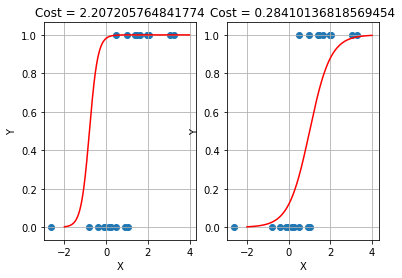

In [16]:
def sigmoid(x, a, b):
    return 1 / (1 + np.exp(-(a + b * x)))

def cost_func(X, Y, a, b):
    m = len(X)
    return - 1/m * np.sum(Y * np.log(sigmoid(X, a, b)) + (1 - Y) * np.log(1 - sigmoid(X, a, b)))

plt.subplot(1, 2, 1)
t = np.arange(-2, 4, 0.01)

plt.scatter(X, Y)
plt.plot(t, sigmoid(t, 4, 5), 'red')
plt.grid(True)
plt.title('Cost = ' + str(cost_func(X, Y, 4, 5)))
plt.xlabel("X")
plt.ylabel("Y")

plt.subplot(1, 2, 2)
plt.scatter(X, Y)
plt.plot(t, sigmoid(t, -2, 2), 'red')
plt.grid(True)
plt.title('Cost = ' + str(cost_func(X, Y, -2, 2)))
plt.xlabel("X")
plt.ylabel("Y")

plt.show()

The cost function of the logistic model has a unique critical point and it is a global minimum. However, it can't be found explicitly by solving the system of equations
$$
\frac{\partial E}{\partial a}=\frac{\partial E}{\partial b}=0
$$

## Method


Given a function of two variables $f(x,y),$ the gradient vector $\nabla f = \left(\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}\right)$ is perpendicular to level curves of $f$ and points in the direction of the function's most rapid growth. The opposite vector $-\nabla f$ indicates the direction at which the function decreases most rapidly.

Suppose that we want to find a local minimum of a function $f(x,y)$ that is hard to calculate directly. We can start at some point $(x_0,y_0)$ and then make small steps in the direction of the gradient vector, i.e., 
\begin{align*}
(x_1,y_1) &= (x_0,y_0) - \alpha \nabla f(x_0,y_0)\\
(x_2,y_2) &= (x_1,y_1) - \alpha \nabla f(x_1,y_1)\\
(x_3,y_3) &= (x_2,y_2) - \alpha \nabla f(x_2,y_2)\\
\end{align*}
and so on. The constant $\alpha$ is called the *learning rate*.

This is the method of *gradient descent*. Below we apply $20$ steps of gradient descent to find an approximation to the local minimum of the function $f(x,y) = (x-2.36)^2 + (y-7.82)^2$ with $\alpha=0.1$ and $(x_0,y_0)=(0,0)$.

We also plot the trajectory of the gradient descent.

In [17]:
def f(x, y):
    return (x - 2.36) ** 2 + (y - 7.82) ** 2

def gradf(x, y):
    return 2 * (x-2.36), 2 * (y-7.82)

X, Y = np.meshgrid(np.linspace(-5, 5, 201),
                   np.linspace(0, 10, 201))
Z = f(X,Y)

learning_rate = 0.1

Traj = np.zeros((21, 2))

for i in range(1,21):
    Traj[i] = Traj[i-1] - learning_rate * np.array(gradf(Traj[i-1, 0], Traj[i-1, 1]))

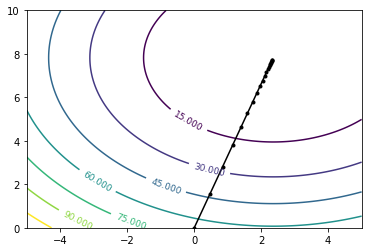

Point of min =  [2.33279105 7.72984154]


In [18]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)
plt.plot(Traj[:,0], Traj[:,1], marker='.', color = 'black')
plt.show()
print("Point of min = ", Traj[20])

While there is nothing fundamentally wrong with the example above, it is more convenient to change the function `gradf` so that its input and output are vectors rather than pairs of independent variables. Another change that we are going to make is not assigning a specific number of steps in advance. Instead, we will stop the descent when the norm of the gradient vector is less than 0.001.

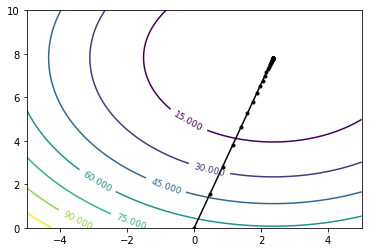

Point of min =  [2.35987151 7.81957424]
Num of iterations =  45


In [19]:
def gradf(X):
    # the input X is a vector with two entries 
    # the output is also a vector with two entries
    return 2 * (X - np.array([2.36, 7.82]))

Traj = np.zeros((1, 2))

while np.linalg.norm(gradf(Traj[-1])) > 0.001:
    Traj = np.concatenate((Traj, [Traj[-1] - learning_rate * gradf(Traj[-1])]))
    
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)
plt.plot(Traj[:,0], Traj[:,1], marker='.', color = 'black')
plt.show()
print("Point of min = ", Traj[-1])
print("Num of iterations = ", Traj.shape[0])

## Issues with gradient descent

If the objective function is convex, then the method of gradient descent will converge to the unique point of minimum provided the learning rate is right. But what if the function is not convex?

### Example

Consider the function
$$
f(x,y) = 2y e^{-(x-1)^2-y^2} + 3x e^{-x^2 -(y-1)^2}
$$
Below is its contour plot. As we can see, the function has two local minima and is almost flat at infinity.

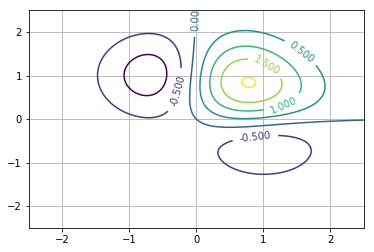

In [20]:
def f(x,y):
    return 2 * y * np.exp(-(x-1) ** 2 - y ** 2) + 3 * x * np.exp(-x ** 2 - (y-1) ** 2)

X, Y = np.meshgrid(np.linspace(-2.5, 2.5, 501),
                   np.linspace(-2.5, 2.5, 501))
Z = f(X, Y)

my_plot = plt.contour(X, Y, Z)
plt.clabel(my_plot, inline=1, fontsize=10)
plt.grid(True)
plt.show()

If we start gradient descent at a wrong point, we may end up at a local minimum that is not the global minimim. For example, below we start at $(1,0)$ and get a local but not the global minimum:

In [21]:
def gradf(X):
    # the input X is a vector with two entries 
    # the output is also a vector with two entries
    # for convenience, we introduce some extra variables
    x = X[0]
    y = X[1]
    dfdx = np.exp(-x**2 - y**2 - 1) * ((3-6*x**2) * np.exp(2*y)-4 * (x-1) *y * np.exp(2*x))
    dfdy = np.exp(-x**2 - y**2 - 1) * ((2-4*y**2) * np.exp(2*x)-6 * (y-1) *x * np.exp(2*y))
    return np.array([dfdx, dfdy])

learning_rate = 0.1
Traj = np.array([[1, 0]])

while np.linalg.norm(gradf(Traj[-1])) > 0.001:
    Traj = np.concatenate((Traj, [Traj[-1] - learning_rate * gradf(Traj[-1])]))
    

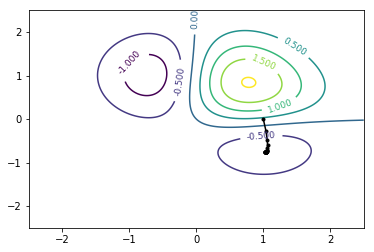

Point of min =  [ 1.03162318 -0.7587922 ]
Num of iterations =  29


In [22]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)
plt.plot(Traj[:,0], Traj[:,1], marker='.', color = 'black')
plt.show()
print("Point of min = ", Traj[-1])
print("Num of iterations = ", Traj.shape[0])

Starting at $(1,1)$, we just end up nowhere after a lot of iterations.

In [23]:
Traj = np.array([[1, 1]])

while np.linalg.norm(gradf(Traj[-1])) > 0.001:
    Traj = np.concatenate((Traj, [Traj[-1] - learning_rate * gradf(Traj[-1])]))
    

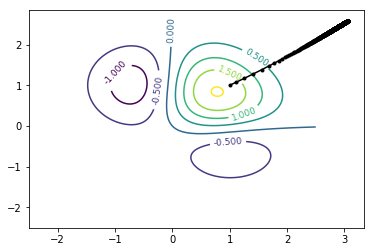

Point of min =  [3.05844832 2.58506176]
Num of iterations =  1795


In [24]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)
plt.plot(Traj[:,0], Traj[:,1], marker='.', color = 'black')
plt.show()
print("Point of min = ", Traj[-1])
print("Num of iterations = ", Traj.shape[0])

But if we start at $(0,0)$, we get the global minimum:

In [25]:
Traj = np.array([[0, 0]])

while np.linalg.norm(gradf(Traj[-1])) > 0.001:
    Traj = np.concatenate((Traj, [Traj[-1] - learning_rate * gradf(Traj[-1])]))
    

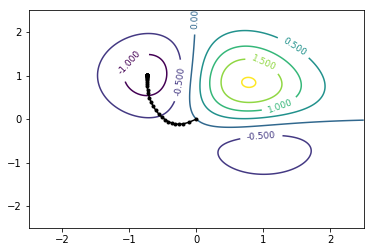

Point of min =  [-0.73187965  1.01428872]
Num of iterations =  40


In [26]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)
plt.plot(Traj[:,0], Traj[:,1], marker='.', color = 'black')
plt.show()
print("Point of min = ", Traj[-1])
print("Num of iterations = ", Traj.shape[0])

To increase the likelyhood of getting the **global** instead of a **local** minimum, one can try to generate a lot of initial  points at random, run the gradient descent starting at each one, and then choose the point with the smallest value of the objective function.

# Particle Swarm Optimization

The method of gradient descent works fine when the objective function is given in an explicit form, i.e., as a formula. This, however, is not always the case. After the midterm break you will see an example of this in your course project. Now let's just look at some toy example.

### Example

Let the function $f(x,y)$ be defined as follows. First, we construct the matrix
$$
A =
\begin{bmatrix}
x & 1 & y \\
1 & -x & x \\
y & x & 3
\end{bmatrix}
$$
Note that the matrix is symmetric and hence its eigenvalues are real. We define $f(x,y)$ to be the largest eigenvalue of the matrix $A$.

The function $f(x,y)$ can be computed for any specific values of $x$ and $y$, but we can hardly express it in an explicit form (it may be possible, but very complicated) and there is little chance that we can find the gradient of the function $f$ and apply gradient descent. However, since the function can be computed, we can plot its level curves in Python:

In [27]:
def f(x, y):
    A = np.mat([[x, 1, y], [1, -1, x], [y, x, 3]])
    eigen_values = np.linalg.eig(A)[0]
    return np.max(eigen_values)

f = np.vectorize(f)

X, Y = np.meshgrid(np.linspace(-3, 3, 61),
                   np.linspace(-3, 3, 61))
Z = f(X,Y)

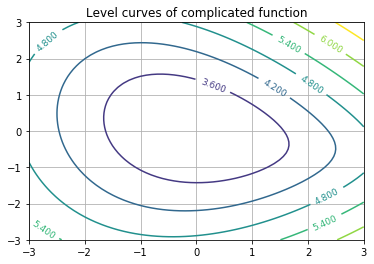

In [28]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)
plt.grid(True)
plt.title("Level curves of complicated function")
plt.show()

*Particle Swarm Optimization*, or just *PSO* is a special algorithm for finding the minimum value of an objective function that does not have an explicit form. It is highly recommended to read the [Wikipedia article](https://en.wikipedia.org/wiki/Particle_swarm_optimization) about PSO.

There is a package for PSO in Python. However, it is not available in Anaconda by default and you will have to download it by yourself. To do it, run Anaconda Prompt and type the following command in Anaconda Prompt:
`pip install --upgrade pyswarm`

Then restart Jupyter Notebook.

More details are available on the [pyswarm page](https://pythonhosted.org/pyswarm/).

Below is an example of particle swarm optimization. We find the minimum of the function $f(x,y)$ subject to the constraints $-3\le x\le 3$ and $-3\le y\le 3$. Note that 
1. The objective function must be a function of one vector input and one scalar output
2. The objective function is passed to `pso` as one of the input variables
3. The algorithm is probabilistic and each time you run it, slightly different results are obtained

In [29]:
from pyswarm import pso

def objective_function(X):
    x = X[0]
    y = X[1]
    A = np.mat([[x, 1, y], [1, -1, x], [y, x, 3]])
    eigen_values = np.linalg.eig(A)[0]
    return np.max(eigen_values)

lb = [-3, -3] # lower bounds for x and y
ub = [3, 3] # upper bounds for x and y

xopt, fopt = pso(objective_function, lb, ub)

print("Minimum point = ", xopt)
print("Minimum value = ", fopt)

Stopping search: Swarm best objective change less than 1e-08
Minimum point =  [-0.00014467  0.00010209]
Minimum value =  3.0000000068129804


## Exercise 1

The following Python code chunk plots level curves of the function
$$
f(x,y)= e^{-x^2-y^2}\left((x-0.4)^2+(y+0.3)^2\right)
$$
for $-1.5\le x\le 0$ and $0\le y \le 1.5$. Change it so that it plots level curves of the same function for $-1.5\le x\le 1.5$ and $-1.5\le y\le 1.5$ all in black color and with labels indicating the value of $f(x,y)$ along the curve. Give some title to the plot.

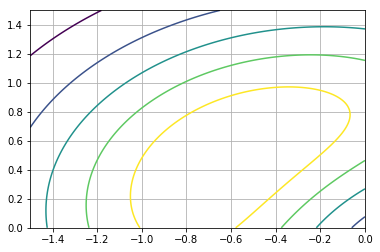

In [30]:
def f(x, y):
    return np.exp(-x ** 2 - y **2) * ((x - 0.4) ** 2 + (y + 0.3) ** 2)

X, Y = np.meshgrid(np.linspace(-1.5, 0, 151),
                   np.linspace(0, 1.5, 151))
Z = f(X, Y)

my_plot = plt.contour(X, Y, Z)
plt.grid(True)
plt.show()

## Solution

Type your code in the code cell below

## Exercise 2

Plot the graph and level curves of the function
$$
f(x,y)=e^{-2x^2 - 3y^2}
\left(\cos(5x-6.2y-1)-\sin(5.6x+0.2)\right)
$$
for $-1.5\leq x\leq 1.5$ and $-1.5\leq y\leq 1.5$

## Solution

Type your code for plotting the graph of the function in the code cell below

Type your code for plotting the level curves of the function in the code cell below

## Exercise 3

Apply the method of gradient descent to find a point of local minimum of the function
$$
f(x,y) = e^{-2x^2-3y^2}\left(\cos(5x-6.2y-1) - \sin(5.6x+0.2)\right)
$$
starting from the initial point $(-0.5,0)$. Stop when 
$\|\nabla f\|\le 10^{-3}$. Plot the level curves of the function and the trajectory of gradient descent. Print the coordinates of the point of minimum that you found and the number of iterations.

Please calculate $\nabla f$ explicitly by hands. This is a good practice for Calculus III.

## Solution

Type your code in the code cell below

## Exercise 4

Here, we will still be looking for the minimum point of the function
$$
f(x,y)=e^{-2x^2-3y^2}\left(\cos(5x-6.2y-1)-\sin(5.6x+0.2)\right)
$$
However, now, write a Python function that accepts the following five variables as input: 
1. A function for calculating the gradient vector of f
2. Initial point
3. The learning rate
4. The maximum number of iterations
5. The required precision

and returns the terminal point of the gradient descent. Besides, your function should plot the trajectory of the gradient descent.

Then generate 50 random points in the square $-1\leq x\leq 1$ and $-1\leq y\leq 1$ and run gradient descent 50 times, each time stopping it either when $\nabla f <10^{-3}$ or when the number of steps exceeds $100$. Then print the coordinates of the best approximation to the minimum that you found and the minimum value of the function. Plot the trajectory of each gradient descent and indicate the point of the global minimum that you found on the plot.

Note that 50 instances of gradient descent may be run in parallel rather than one after another. Use the loop 
`[gradient_descent(...) for x in ...]` or vectorize the function `gradient_descent` rather than 

`for x in ...:
    gradient_decent(...)`
    

## Solution

Use the following template to write your code:

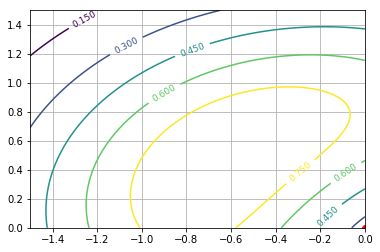

Min point =  [0. 0.]
Min value =  0.25


In [31]:
def gradient_descent(grad_function, initial_point, learning_rate, max_iterations, required_precision):
    # We are going to run gradient descent and return its terminal point
    # We will also make it plot the whole trajectory
    Traj = np.array(initial_point).reshape(1, 2) # here we initialize the trjectory
    
    # Replace True with the condition of stopping when the maximum number of iterations exceeded
    while (True) & (len(Traj) < max_iterations):
        # Replace Traj[-1] with the correct next iteration of gradient descent
        Traj = np.concatenate((Traj, [Traj[-1]]))
    plt.plot(Traj[:,0], Traj[:,1], color = 'black')
    return Traj[-1]

plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, fontsize=9, inline=1)

# Replace with initializing with random values in the interval [-1, 1]
initial_points = np.zeros((50, 2))

# Assign correct values to learning rate, maximal number of iternations, and precision
terminal_points = [gradient_descent(gradf, x, 0, 1, 0) for x in initial_points]

f_values = [f(x[0], x[1]) for x in terminal_points]
ind_min = np.argmin(f_values)

plt.grid(True)
plt.plot(terminal_points[ind_min][0], terminal_points[ind_min][1], marker = 'o', color = "red")
plt.show()

print("Min point = ", terminal_points[ind_min])
print("Min value = ", f_values[ind_min])

## Exercise 5

Find the minimum of the function 
$$
f(x,y)=e^{-2x^2-3y^2}\left(\cos(5x-6.2y-1)-\sin(5.6x+0.2)\right)
$$
using Particle Swarm Optimization. Print the coordinates of the minimum and the value of the objective function at the point of minimum. Use the constraints $-1.5\le x\le 1.5$ and $-1.5\le y\le 1.5$.

## Solution

Type your answer in the code cell below

# Conclusion

In today's lab, we reviewed some material familiar from Calculus III - gradient and criticial points. The theoretical foundation of the gradient descent method is the fact that the gradient vector is perpendicular to level curves and points at the direction of the most rapid growth of the function. An application of gradient descent is fitting model parameters into data. Linear and logistic regression should be familiar from Probability and Statistics. 

If the objective function cannot be expressed in a closed form, we need to use other methods to find its minimum, such as Particle Swarm Optimization.

Hopefully, Python plotting tools will be helpful for your work in Calculus, Probability and Statistics courses. 

Now please fill the following survey form to provide your feedback on the course:

https://tinyurl.com/mh2401-week7-feedback

For instance, the course instructors need to know if this handout is sufficient to understand the material and if lab assistants are helpful and their explanations are clear.